In [1]:
#!/usr/bin/env python3
import os
import json
import h5py
import argparse
import pandas as pd
import numpy as np
import tinydb as db
from tinydb.storages import MemoryStorage
import matplotlib.pyplot as plt
# plt.style.use('../clint.mpl')
from matplotlib.colors import LogNorm

from pygama import DataGroup
import pygama.io.lh5 as lh5
import pygama.analysis.histograms as pgh
import pygama.analysis.peak_fitting as pgf

Load background data from the run of interest

In [2]:
bkg_dg = DataGroup('cage.json', load=True)
bkg_run = 'run==30 and skip==False'
# bkg_run = 'run==34 and skip==False'
bkg_dg.file_keys.query(bkg_run, inplace=True)
view_cols = ['runtype', 'run', 'cycle', 'startTime', 'runtime', 'threshold']
print(bkg_dg.file_keys[view_cols])

Loading file key list from: ./fileDB.h5
     runtype  run  cycle     startTime    runtime  threshold
493  oppi_v2   30    496  1.599176e+09   0.096370      256.0
494  oppi_v2   30    497  1.599176e+09  29.981470        8.0
495  oppi_v2   30    498  1.599178e+09  29.980170        8.0
496  oppi_v2   30    499  1.599180e+09  29.970513        8.0
497  oppi_v2   30    500  1.599182e+09  29.977917        8.0
498  oppi_v2   30    501  1.599183e+09  29.986194        8.0
499  oppi_v2   30    502  1.599185e+09  29.993787        8.0
500  oppi_v2   30    503  1.599187e+09  29.985092        8.0
501  oppi_v2   30    504  1.599189e+09  29.978162        8.0
502  oppi_v2   30    505  1.599191e+09  29.969954        8.0
503  oppi_v2   30    506  1.599192e+09  29.990436        8.0
504  oppi_v2   30    507  1.599194e+09  29.988058        8.0
505  oppi_v2   30    508  1.599196e+09  29.995731        8.0
506  oppi_v2   30    509  1.599198e+09  29.989780        8.0
507  oppi_v2   30    510  1.599200e+09  29.98

Load alpha data from the run of interest

In [3]:
alpha_dg = DataGroup('cage.json', load=True)
alpha_run = 'run==31 and skip==False'
# alpha_run = 'run==35 and skip==False'
alpha_dg.file_keys.query(alpha_run, inplace=True)
view_cols = ['runtype', 'run', 'cycle', 'startTime', 'runtime', 'threshold']
print(alpha_dg.file_keys[view_cols])

Loading file key list from: ./fileDB.h5
     runtype  run  cycle     startTime    runtime  threshold
528  oppi_v2   31    531  1.599257e+09  29.987254        8.0
529  oppi_v2   31    532  1.599259e+09  29.992105        8.0
530  oppi_v2   31    533  1.599261e+09  29.985067        8.0
531  oppi_v2   31    534  1.599263e+09   7.420690        8.0


Plot raw energy histogram of the background data, then alpha data, from DSP files
First get dsp data, runtimes so we can normalize by time

First get file list and load background energy data (numpy array)

In [ ]:
# get file list and load background energy data (numpy array)
lh5_dir = os.path.expandvars(bkg_dg.config['lh5_dir'])
bkg_dsp_list = lh5_dir + bkg_dg.file_keys['dsp_path'] + '/' + bkg_dg.file_keys['dsp_file']
bkg_edata = lh5.load_nda(bkg_dsp_list, ['trapEmax'], 'ORSIS3302DecoderForEnergy/dsp')
bkg_rt_min = bkg_dg.file_keys['runtime'].sum()
bkg_u_start = bkg_dg.file_keys.iloc[0]['startTime']
bkg_t_start = pd.to_datetime(bkg_u_start, unit='s') # str

Get file list for alpha data

In [ ]:
# get file list and load alpha energy data (numpy array)
lh5_dir = os.path.expandvars(alpha_dg.config['lh5_dir'])
alpha_dsp_list = lh5_dir + alpha_dg.file_keys['dsp_path'] + '/' + alpha_dg.file_keys['dsp_file']
alpha_edata = lh5.load_nda(alpha_dsp_list, ['trapEmax'], 'ORSIS3302DecoderForEnergy/dsp')
alpha_rt_min = alpha_dg.file_keys['runtime'].sum()
alpha_u_start = alpha_dg.file_keys.iloc[0]['startTime']
alpha_t_start = pd.to_datetime(alpha_u_start, unit='s') # str

Create background histogram

In [ ]:
# Create background histogram, normalized by runtime
elo, ehi, epb = 0, 25000, 10 
etype = 'trapEmax'

bkg_ene_uncal = bkg_edata[etype]
bkg_hist, bins, _ = pgh.get_hist(bkg_ene_uncal, range=(elo, ehi), dx=epb)

# normalize by runtime in seconds
bkg_hist_rt = np.divide(bkg_hist, bkg_rt_min * 60)

Create alpha histogram

In [ ]:
# Create alpha histogram, normalized by runtime

alpha_ene_uncal = alpha_edata[etype]
alpha_hist, bins, _ = pgh.get_hist(alpha_ene_uncal, range=(elo, ehi), dx=epb)

# normalize by runtime in seconds
alpha_hist_rt = np.divide(alpha_hist, alpha_rt_min * 60)

Plot background spectrum

In [ ]:
# Plot the histograms
plt.semilogy(bins[1:], bkg_hist_rt, ds='steps', c='b', lw=1,
            label=f'{etype}, {bkg_rt_min:.2f} mins')

plt.xlabel(etype, ha='right', x=1)
plt.ylabel('cts / sec', ha='right', y=1)
plt.legend()
plt.title(f'Background run: {bkg_run}')
plt.show()

Plot alpha spectrum

In [ ]:
# Plot the alpha histogram
plt.semilogy(bins[1:], alpha_hist_rt, ds='steps', c='b', lw=1,
            label=f'{etype}, {alpha_rt_min:.2f} mins')

plt.xlabel(etype, ha='right', x=1)
plt.ylabel('cts / sec', ha='right', y=1)
plt.legend()
plt.title(f'Alpha run: {alpha_run}')
plt.show()

Subtract the Background histogram from the alpha histogram

In [ ]:
hist_bkg_sub = alpha_hist_rt - bkg_hist_rt

Plot background-subtracted histogram 

In [ ]:
# Plot the background-subtracted histogram
plt.semilogy(bins[1:], hist_bkg_sub, ds='steps', c='b', lw=1,
            label=f'{etype}, background subtracted')

plt.xlabel(etype, ha='right', x=1)
plt.ylabel('cts / sec', ha='right', y=1)
plt.legend()
plt.title(f'Background subtracted, Alpha run: {alpha_run}')
plt.show()

Load hit data from local directory

In [4]:
lh5_dir = bkg_dg.lh5_user_dir #if user else dg.lh5_dir
print(lh5_dir)
# exit()
bkg_hit_list = lh5_dir + bkg_dg.file_keys['hit_path'] + '/' + bkg_dg.file_keys['hit_file']
# bkg_df_hit = lh5.load_dfs(bkg_hit_list, ['trapEmax', 'bl','bl_sig','A_10','ts_sec', 'dcr_raw', 'dcr_ftp', 'dcr_max'], 'ORSIS3302DecoderForEnergy/hit')
bkg_df_hit = lh5.load_dfs(bkg_hit_list, ['trapEmax', 'bl','bl_sig','A_10','ts_sec', 'dcr'], 'ORSIS3302DecoderForEnergy/hit')
# print(df_hit)
print(bkg_df_hit.columns)

# bkg_dsc = bkg_df_hit[['bl','bl_sig','A_10','ts_sec', 'dcr_raw']].describe()
bkg_dsc = bkg_df_hit[['bl','bl_sig','A_10','ts_sec', 'dcr']].describe()
print(bkg_dsc)

/global/homes/g/gothman/projecta/CAGE_lh5_joule/
Index(['trapEmax', 'bl', 'bl_sig', 'A_10', 'ts_sec', 'dcr'], dtype='object')
                 bl        bl_sig          A_10        ts_sec           dcr
count  3.832642e+06  3.832642e+06  3.832642e+06  3.832642e+06  3.811138e+06
mean   9.376628e+03  4.548370e+00  8.493299e+01  8.926595e+02           inf
std    1.624361e+03  2.515147e+01  2.097900e+02  5.191997e+02           NaN
min    0.000000e+00  0.000000e+00  1.714317e+00  2.931742e-02 -4.003872e+06
25%    9.287154e+03  4.002597e+00  2.292959e+01  4.429820e+02 -9.391513e-01
50%    9.298229e+03  4.174541e+00  3.714658e+01  8.859437e+02  3.767933e-02
75%    9.304571e+03  4.440948e+00  7.259209e+01  1.341848e+03  1.016084e+00
max    4.393224e+04  9.631724e+03  3.679710e+03  1.800015e+03           inf


In [10]:
lh5_dir = alpha_dg.lh5_user_dir #if user else dg.lh5_dir
print(lh5_dir)
alpha_hit_list = lh5_dir + alpha_dg.file_keys['hit_path'] + '/' + alpha_dg.file_keys['hit_file']
print(alpha_hit_list)
# alpha_df_hit = lh5.load_dfs(alpha_hit_list, ['trapEmax', 'bl','bl_sig','A_10','ts_sec', 'dcr_raw', 'dcr_ftp', 'dcr_max'], 'ORSIS3302DecoderForEnergy/hit')
alpha_df_hit = lh5.load_dfs(alpha_hit_list, ['trapEmax', 'bl','bl_sig','A_10','ts_sec', 'dcr_raw'], 'ORSIS3302DecoderForEnergy/hit')
# print(df_hit)
print(alpha_df_hit.columns)

# alpha_dsc = alpha_df_hit[['bl','bl_sig','A_10','ts_sec', 'dcr_raw', 'dcr_ftp', 'dcr_max']].describe()
alpha_dsc = alpha_df_hit[['bl','bl_sig','A_10','ts_sec', 'dcr_raw']].describe()
print(alpha_dsc)

/global/homes/g/gothman/projecta/CAGE_lh5_joule/
528    /global/homes/g/gothman/projecta/CAGE_lh5_joul...
529    /global/homes/g/gothman/projecta/CAGE_lh5_joul...
530    /global/homes/g/gothman/projecta/CAGE_lh5_joul...
531    /global/homes/g/gothman/projecta/CAGE_lh5_joul...
dtype: object
Index(['trapEmax', 'bl', 'bl_sig', 'A_10', 'ts_sec', 'dcr_raw'], dtype='object')
                  bl         bl_sig           A_10         ts_sec  \
count  385461.000000  385461.000000  385461.000000  385461.000000   
mean     9079.127930       4.329427      72.080994     847.054185   
std      1507.844116      46.062943     189.287857     530.939624   
min         0.000000       0.000000       1.499873       0.036842   
25%      9282.013672       3.495314      18.107244     365.704441   
50%      9293.638672       3.641525      29.810297     824.257389   
75%      9299.955078       3.878845      59.423962    1310.589926   
max     43856.105469   16691.498047    2933.832031    1799.526282   

      

Now plot baseline vs E

In [ ]:
# Background Baseline vs E
elo, ehi, epb = 0, 50, 1
blo, bhi, bpb = 0, 10000, 100
nbx = int((ehi-elo)/epb)
nby = int((bhi-blo)/bpb)

h = plt.hist2d(bkg_df_hit['trapEmax'], bkg_df_hit['bl'], bins=[nbx,nby],
                       range=[[elo, ehi], [blo, bhi]], cmap='jet')

cb = plt.colorbar(h[3], ax=plt.gca())
plt.xlabel('trapEmax', ha='right', x=1)
plt.ylabel('bl', ha='right', y=1)
plt.title('Baseline, background')
# plt.tight_layout()
plt.show()

In [ ]:
# Alpha Baseline vs E
elo, ehi, epb = 0, 50, 1
blo, bhi, bpb = 0, 10000, 100
nbx = int((ehi-elo)/epb)
nby = int((bhi-blo)/bpb)

h = plt.hist2d(alpha_df_hit['trapEmax'], alpha_df_hit['bl'], bins=[nbx,nby],
                       range=[[elo, ehi], [blo, bhi]], cmap='jet')

cb = plt.colorbar(h[3], ax=plt.gca())
plt.xlabel('trapEmax', ha='right', x=1)
plt.ylabel('bl', ha='right', y=1)
plt.title('Baseline, alpha')
# plt.tight_layout()
plt.show()

Make a cut based on BL value

In [ ]:
# make a formal baseline cut from 1d histogram
hE, bins, vE = pgh.get_hist(alpha_df_hit['bl'], range=(blo, bhi), dx=bpb)
xE = bins[1:]
plt.semilogy(xE, hE, c='b', ds='steps')

bl_cut_lo, bl_cut_hi = 8000,10000
plt.axvline(bl_cut_lo, c='r', lw=1)
plt.axvline(bl_cut_hi, c='r', lw=1)

plt.xlabel('bl', ha='right', x=1)
plt.ylabel('counts', ha='right', y=1)
plt.show()

Use BL cut from above, create A/E

In [ ]:
# Background A_10/trapEmax vs trapEmax (A/E vs E)

# use baseline cut
bkg_df_cut = bkg_df_hit.query('bl > 8000 and bl < 10000').copy()

# add new A/E column
bkg_df_cut['aoe'] = bkg_df_cut['A_10'] / bkg_df_cut['trapEmax']

In [11]:
# Alpha A_10/trapEmax vs trapEmax (A/E vs E)

# use baseline cut
alpha_df_cut = alpha_df_hit.query('bl > 8000 and bl < 10000').copy()

# add new A/E column
alpha_df_cut['aoe'] = alpha_df_cut['A_10'] / alpha_df_cut['trapEmax']

Plot A/E vs E

In [12]:
alo, ahi, apb = 0.0, 0.09, 0.0001
elo, ehi, epb = 0, 25000, 10
# elo, ehi, epb = 0, 3000, 10
# elo, ehi, epb = 0, 6000, 10
        

nbx = int((ehi-elo)/epb)
nby = int((ahi-alo)/apb)

h = plt.hist2d(bkg_df_cut['trapEmax'], bkg_df_cut['aoe'], bins=[nbx,nby],
                range=[[elo, ehi], [alo, ahi]], cmap='jet', norm=LogNorm())

plt.xlabel('trapEmax', ha='right', x=1)
plt.ylabel('A/E', ha='right', y=1)
plt.title('Background A/E')
plt.tight_layout()
plt.show()

NameError: name 'bkg_df_cut' is not defined

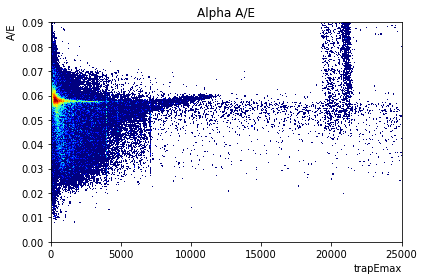

In [13]:
alo, ahi, apb = 0.0, 0.09, 0.0001
elo, ehi, epb = 0, 25000, 10
# elo, ehi, epb = 0, 3000, 10
# elo, ehi, epb = 0, 6000, 10
        

nbx = int((ehi-elo)/epb)
nby = int((ahi-alo)/apb)

h = plt.hist2d(alpha_df_cut['trapEmax'], alpha_df_cut['aoe'], bins=[nbx,nby],
                range=[[elo, ehi], [alo, ahi]], cmap='jet', norm=LogNorm())

plt.xlabel('trapEmax', ha='right', x=1)
plt.ylabel('A/E', ha='right', y=1)
plt.title('Alpha A/E')
plt.tight_layout()
plt.show()

Plot DCR vs E

In [ ]:
# Bkg show DCR vs E
etype = 'trapEmax'
#       elo, ehi, epb = 0, 6000, 10
elo, ehi, epb = 0, 25000, 10
# dlo, dhi, dpb = -1000, 1000, 10
# dlo, dhi, dpb = -0.25, 0.25, 0.05
dlo, dhi, dpb = -100., 100., 1
# dlo, dhi, dpb = -1000., 0., 1


nbx = int((ehi-elo)/epb)
nby = int((dhi-dlo)/dpb)

h = plt.hist2d(bkg_df_cut['trapEmax'], bkg_df_cut['dcr'], bins=[nbx,nby],
                range=[[elo, ehi], [dlo, dhi]], cmap='jet', norm=LogNorm())

plt.xlabel('trapEmax', ha='right', x=1)
plt.ylabel('DCR_ftp', ha='right', y=1)
plt.title('Background DCR')
# plt.tight_layout()
# plt.savefig('./plots/bkg_dcr_raw_run34.png', dpi=200)
plt.show()

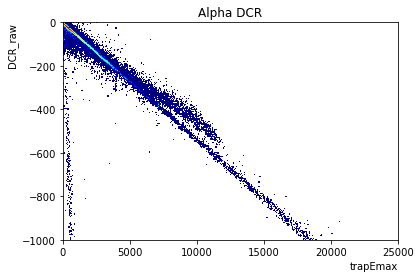

In [16]:
# Alpha show DCR vs E
etype = 'trapEmax'
#       elo, ehi, epb = 0, 6000, 10
elo, ehi, epb = 0, 25000, 10
# dlo, dhi, dpb = -1000, 1000, 10
# dlo, dhi, dpb = -0.25, 0.25, 0.0005
# dlo, dhi, dpb = -100., 100., 1
# dlo, dhi, dpb = -1000., 0., 1
dlo, dhi, dpb = -1000., 0., 1

nbx = int((ehi-elo)/epb)
nby = int((dhi-dlo)/dpb)

h = plt.hist2d(alpha_df_cut['trapEmax'], alpha_df_cut['dcr_raw'], bins=[nbx,nby],
                range=[[elo, ehi], [dlo, dhi]], cmap='jet', norm=LogNorm())

plt.xlabel('trapEmax', ha='right', x=1)
plt.ylabel('DCR_raw', ha='right', y=1)
plt.title('Alpha DCR')
# plt.tight_layout()
# plt.savefig('./plots/alpha_dcr_raw_run35.png', dpi=200)
plt.show()